In [279]:
import numpy as np
from numpy.linalg import inv
from ott.geometry.costs import SqEuclidean
from scipy.stats import norm, uniform

import matplotlib.pyplot as plt

In [280]:
np.random.seed(5)

num_a = 50
num_b = 50
num_blocked_pairs = 200

num_iters = 200

In [281]:
gamma_0 = 20.0 # regularisation
gamma_c = 2.0 # column constraints
gamma_r = 2.0 # row constraints

# select which constraints to enforce
rows_to_relax = np.random.choice([0,1], size=(num_a,1), p=[0.75,0.25])
cols_to_relax = np.random.choice([0,1], size=(1,num_b), p=[0.75,0.25])

row_exponent_0 = gamma_r/(1+gamma_r) * rows_to_relax
row_exponent_0[rows_to_relax == 0] = 1.0
row_exponent_1 = rows_to_relax * (-1/gamma_r) # 1s are implicit here

col_exponent_0 = gamma_c/(1+gamma_c) * cols_to_relax
col_exponent_0[cols_to_relax == 0] = 1.0
col_exponent_1 = cols_to_relax * (-1/gamma_c) # 1s are implicit here

In [282]:
# locs
a = np.arange(num_a)
b = np.arange(num_b)
# a = np.random.random(num_a)
# b = np.random.random(num_b)

# weights 
mu = norm.pdf(a, loc=(3/8) * num_a, scale=5.0) #np.random.random(a.shape[0])
mu /= np.sum(mu)
mu_0 = mu.copy()

nu = norm.pdf(b, loc=num_b/2, scale=7.5) #np.random.random(b.shape[0])
nu /= np.sum(nu)
nu_0 = nu.copy()

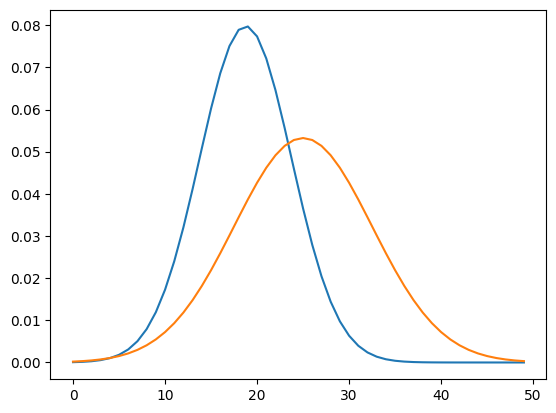

In [283]:
fig, ax = plt.subplots()

ax.plot(a, mu, label='mu(x)', c='tab:blue')
ax.plot(b, nu, label='nu(y)', c='tab:orange')

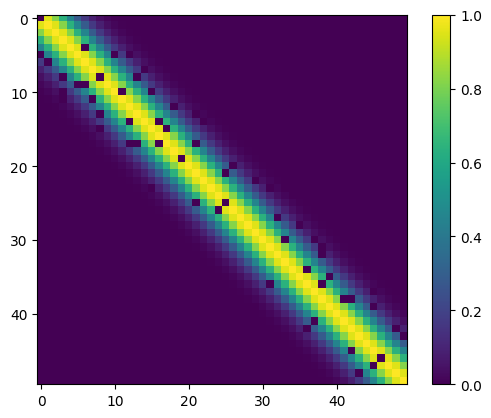

In [284]:
# cost fn
C = SqEuclidean().all_pairs(a.reshape(-1,1), b.reshape(-1,1))

# choose which index pairs to block
l_idxs_x = np.random.choice(np.arange(a.shape[0]), num_blocked_pairs)
l_idxs_y = np.random.choice(np.arange(b.shape[0]), num_blocked_pairs)

# kernel
K = np.pow(np.e, -C / gamma_0)
K[l_idxs_x, l_idxs_y] = 0

plt.imshow(K)
cbar = plt.colorbar()

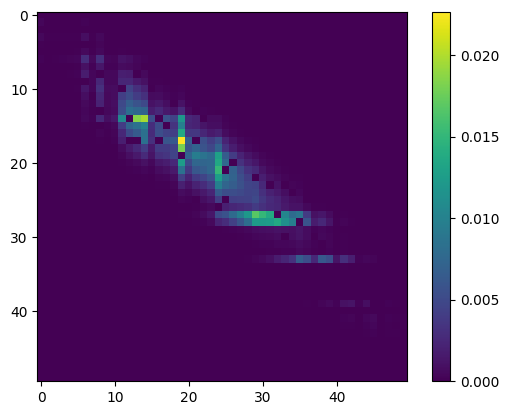

In [285]:
T = K.copy()

for i in range(num_iters):
    D1 = np.divide(mu[:,None], np.sum(T, axis=1, keepdims=True))
    D1 = np.pow(D1, row_exponent_0)
    T = D1 * T
    mu = (np.pow(D1, row_exponent_1) * mu[:,None]).reshape(-1,)

    D2 = np.divide(nu[None,:], np.sum(T, axis=0, keepdims=True))
    D2 = np.pow(D2, col_exponent_0)
    T = D2 * T
    nu = (np.pow(D2, col_exponent_1) * nu[None,:]).reshape(-1,)

# plt.imshow(T, vmin=cbar.vmin, vmax=cbar.vmax)
plt.imshow(T)
plt.colorbar()

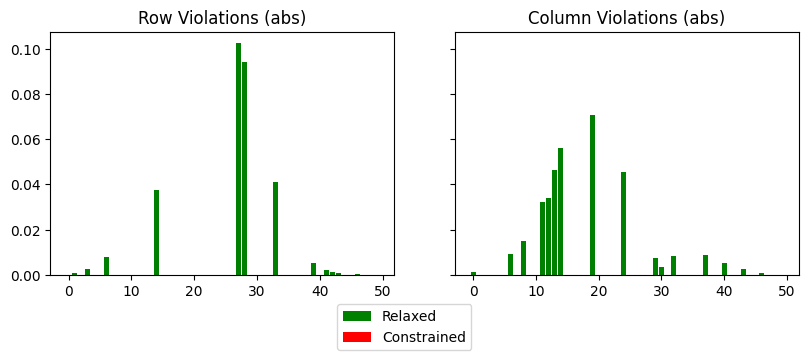

In [287]:
from matplotlib.patches import Patch

# fig, (ax_r, ax_c) = plt.subplots(1,2, figsize=(8,4))
fig, (ax_r, ax_c) = plt.subplots(1,2, figsize=(9,4), sharey='row')

def binary_to_colour(arr):
    colours = np.array(arr, dtype=str)
    colours[arr == 1] = 'green'
    colours[arr == 0] = 'red'
    return colours

ax_r.bar(x=np.arange(num_a), height=np.abs(mu_0 - np.sum(T, axis=1)), color=binary_to_colour(rows_to_relax.reshape(-1,)))
ax_r.set_title('Row Violations (abs)')

ax_c.bar(x=np.arange(num_b), height=np.abs(nu_0 - np.sum(T, axis=0)), color=binary_to_colour(cols_to_relax.reshape(-1,)))
ax_c.set_title('Column Violations (abs)')

fig.tight_layout(pad=4)
fig.legend(labels=['Relaxed', 'Constrained'], handles=[Patch(facecolor='green'), Patch(facecolor='red')], loc='outside lower center')
